In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import shuffle

In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.5 MB/s eta 0:00:00


In [4]:
!pip install torch torchvision

In [5]:
from transformers import AutoTokenizer, AutoModel

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/SC

/content/drive/MyDrive/SC


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv('/content/drive/MyDrive/SC/train.csv')

In [9]:
print ("total rows: ", len(df))

total rows:  20972


In [10]:
df.isnull().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

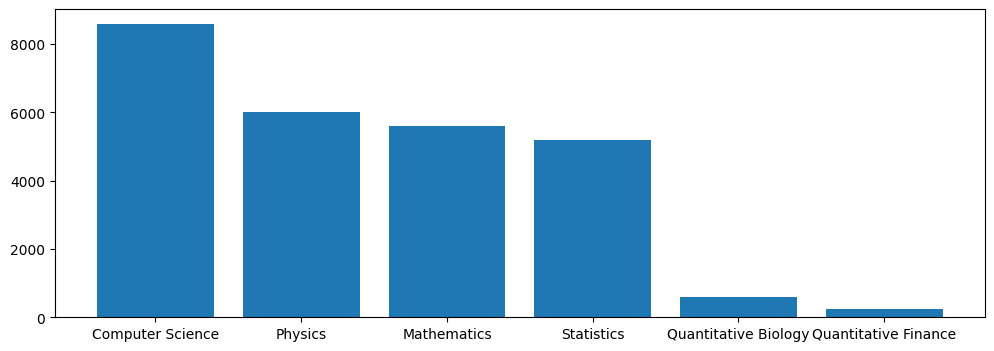

In [11]:
df_classes = df.drop(['ID', 'TITLE', 'ABSTRACT'], axis=1)

column_names = df_classes.columns
X_axis = range(len(column_names))

plt.figure(figsize=(12, 4))
plt.bar(X_axis, df.drop(['ID', 'TITLE', 'ABSTRACT'], axis=1).sum())
plt.xticks(X_axis, column_names)

plt.show()

In [ ]:
torch.manual_seed(42)

In [12]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

max_title_length = 20
max_abstract_length = 300

def tokenize(data, max_length):
    x = str(data)
    tokens = tokenizer.encode_plus(data,
                                   max_length=max_length,
                                   padding="max_length",
                                   truncation=True,
                                   return_tensors="pt")
    return tokens["input_ids"].squeeze(), tokens["attention_mask"].squeeze()

In [13]:
class CustomDataset(Dataset):
    def __init__(self, data_frame, is_test=False):
        self.titles = data_frame["TITLE"].tolist()
        self.abstracts = data_frame["ABSTRACT"].tolist()
        self.is_test = is_test
        if not self.is_test:
            self.labels = data_frame.drop(["ID", "TITLE", "ABSTRACT"], axis=1).values.astype(np.float32)

    def __getitem__(self, index):
        title_input_ids, title_attention_mask = tokenize(self.titles[index], max_title_length)
        abstract_input_ids, abstract_attention_mask = tokenize(self.abstracts[index], max_abstract_length)
        if self.is_test:
            return title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask
        else:
            label = torch.tensor(self.labels[index])
            return title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask, label

    def __len__(self):
        return len(self.titles)

In [14]:
total_rows = len(df)
df = shuffle(df)
train_size = int(total_rows * 0.8)
valid_size = int(total_rows * 0.1)

df_train = df[:train_size]
df_valid = df[train_size:train_size+valid_size]
df_test = df[train_size+valid_size:]

train_dataset = CustomDataset(df_train)
valid_dataset = CustomDataset(df_valid)
test_dataset = CustomDataset(df_test)

In [15]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [20]:
augmented_data = []

for index, label in enumerate(train_dataset.labels):
    # if label[4] == 1 or label[5] == 1:
    #     augmented_data.append(train_dataset[index])
    #     augmented_data.append(train_dataset[index])
    if label[4] == 1:  # 'Quantitative Biology'
        augmented_data.append(train_dataset[index])
    elif label[5] == 1:  # 'Quantitative Finance'
        augmented_data.append(train_dataset[index])

train_loader_augmented = DataLoader(augmented_data, batch_size=batch_size, shuffle=True)
train_loader = torch.utils.data.ConcatDataset([train_dataset, augmented_data])
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)

In [21]:
bert = AutoModel.from_pretrained("bert-base-uncased")
bert.to(device)
bert.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [22]:
class Model(nn.Module):
    def __init__(self, bert_model):
        super(Model, self).__init__()
        self.bert = bert_model
        self.title_emb = nn.Sequential(
            nn.Linear(bert_model.config.hidden_size, 512),
            nn.ReLU()
        )
        self.abstract_emb = nn.Sequential(
            nn.Linear(bert_model.config.hidden_size, 512),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 6)
        )


    def forward(self, title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask):

      title_output = self.bert(input_ids=title_input_ids, attention_mask=title_attention_mask)[0]
      title_emb = torch.mean(title_output, dim=1)
      title_emb = self.title_emb(title_emb)

      abstract_output = self.bert(input_ids=abstract_input_ids, attention_mask=abstract_attention_mask)[0]
      abstract_emb = torch.mean(abstract_output, dim=1)
      abstract_emb = self.abstract_emb(abstract_emb)

      x = torch.cat((title_emb, abstract_emb), dim=-1)
      x = self.mlp(x)
      output = x.unsqueeze(dim=-1)
      return output

In [23]:
model = Model(bert)
model.to(device)

Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [24]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
num_epochs = 5
best_valid_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask, labels = batch
        title_input_ids = title_input_ids.to(device)
        title_attention_mask = title_attention_mask.to(device)
        abstract_input_ids = abstract_input_ids.to(device)
        abstract_attention_mask = abstract_attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask)
        loss = criterion(outputs, labels.unsqueeze(dim=-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_size

    train_loss /= len(train_loader)

    model.eval()
    valid_loss = 0.0
    preds = []
    true_labels = []

    with torch.no_grad():
        for batch in valid_loader:
            title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask, labels = batch
            title_input_ids = title_input_ids.to(device)
            title_attention_mask = title_attention_mask.to(device)
            abstract_input_ids = abstract_input_ids.to(device)
            abstract_attention_mask = abstract_attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask)
            loss = criterion(outputs, labels.unsqueeze(dim=-1))
            valid_loss += loss.item() * batch_size

            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

        valid_loss /= len(valid_loader)
        preds = np.array(preds)
        true_labels = np.array(true_labels)

        preds[preds >= 0.5] = 1.0
        preds[preds < 0.5] = 0.0

        acc_scores = []
        f1_scores = []

        for i in range(true_labels.shape[1]):
            true_labels_i = true_labels[:, i]
            preds_i = preds[:, i]

            acc = accuracy_score(true_labels_i, preds_i)
            f1 = f1_score(true_labels_i, preds_i, average="binary")

            acc_scores.append(acc)
            f1_scores.append(f1)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} , Valid Loss: {valid_loss:.4f}")
    print("Accuracy Scores:", acc_scores)
    print("F1 Scores:", f1_scores)

In [ ]:
model.eval()
test_loss = 0.0
preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask, labels = batch
        title_input_ids = title_input_ids.to(device)
        title_attention_mask = title_attention_mask.to(device)
        abstract_input_ids = abstract_input_ids.to(device)
        abstract_attention_mask = abstract_attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(title_input_ids, title_attention_mask, abstract_input_ids, abstract_attention_mask)
        loss = criterion(outputs, labels.unsqueeze(dim=-1))
        test_loss += loss.item() * batch_size

        preds.extend(torch.sigmoid(outputs).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    preds = np.array(preds)
    true_labels = np.array(true_labels)

    preds[preds >= 0.5] = 1.0
    preds[preds < 0.5] = 0.0

    acc_scores = []
    f1_scores = []

    for i in range(true_labels.shape[1]):
        true_labels_i = true_labels[:, i]
        preds_i = preds[:, i]

        acc = accuracy_score(true_labels_i, preds_i)
        f1 = f1_score(true_labels_i, preds_i, average="binary")

        acc_scores.append(acc)
        f1_scores.append(f1)

print(f"Test Loss: {test_loss:.4f}")
print("Accuracy Scores:", acc_scores)
print("F1 Scores:", f1_scores)

Test Loss: 5.9599
Accuracy Scores: [0.8727359389895138, 0.9408960915157293, 0.9165872259294566, 0.888465204957102, 0.9780743565300286, 0.988560533841754]
F1 Scores: [0.8500842223469961, 0.8906525573192239, 0.8378127896200186, 0.7921847246891651, 0.6515151515151515, 0.6129032258064516]


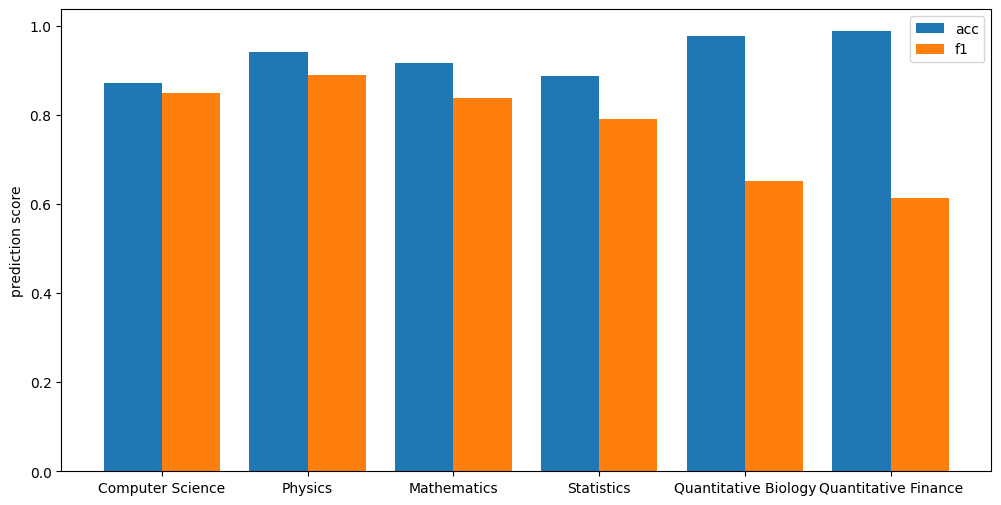

In [ ]:
X_axis = np.arange(len(column_names))

plt.figure(figsize=(12, 6))
plt.bar(X_axis-0.2, acc_scores, width=0.4, label='acc')
plt.bar(X_axis+0.2, f1_scores, width=0.4, label='f1')

plt.xticks(X_axis, column_names)
plt.ylabel('prediction score')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), "model_bert.pth")

In [ ]:
model = Model(bert)
model.load_state_dict(torch.load("model_bert.pth"))
model.eval()

Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True